In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-525a9051-49b6-786f-42c4-c122ab73f8a9)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import series of helper functions for our project
from helper_functions import create_tensorboard_callback, plot_loss_curves, walk_through_dir

In [ ]:
# Import Relevant libraries
import os
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Conv2D, GlobalAvgPool2D, Input
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras import callbacks, optimizers
import numpy as np

In [ ]:
# Get the data directory
train_dir = "/content/drive/MyDrive/Data/100_sports/train/"
valid_dir = "/content/drive/MyDrive/Data/100_sports/valid/"
test_dir = "/content/drive/MyDrive/Data/100_sports/test/"

In [ ]:
# Check to see how many images/classes we have in our data dir?
walk_through_dir("/content/drive/MyDrive/Data/100_sports")

There are 3 directories and 0 images in '/content/drive/MyDrive/Data/100_sports'.
There are 100 directories and 0 images in '/content/drive/MyDrive/Data/100_sports/valid'.
There are 0 directories and 5 images in '/content/drive/MyDrive/Data/100_sports/valid/billiards'.
There are 0 directories and 5 images in '/content/drive/MyDrive/Data/100_sports/valid/canoe slamon'.
There are 0 directories and 5 images in '/content/drive/MyDrive/Data/100_sports/valid/curling'.
There are 0 directories and 5 images in '/content/drive/MyDrive/Data/100_sports/valid/chuckwagon racing'.
There are 0 directories and 5 images in '/content/drive/MyDrive/Data/100_sports/valid/archery'.
There are 0 directories and 5 images in '/content/drive/MyDrive/Data/100_sports/valid/ampute football'.
There are 0 directories and 5 images in '/content/drive/MyDrive/Data/100_sports/valid/bike polo'.
There are 0 directories and 5 images in '/content/drive/MyDrive/Data/100_sports/valid/barell racing'.
There are 0 directories and

### Setup data inputs

In [ ]:
IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode='categorical',
                                                                 image_size=IMG_SIZE)

valid_data = tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                                 label_mode='categorical',
                                                                 image_size=IMG_SIZE)


test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # Don't shuffle test data for prediction analysis


Found 13572 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


### Create checkpoint callback

In [ ]:
checkpoint_path = "100_images_sports_classification_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

### Create data augmentation

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Set up data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name='data_augmentation')

### Setup base model and freeze its layers

In [ ]:
base_model = tf.keras.applications.EfficientNetB7(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False) # put the base model in inference mode so weights which needs to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name='global_avg_pool_layer')(x)
outputs = layers.Dense(len(train_data.class_names), activation='softmax', name='output_layer')(x)

model = tf.keras.Model(inputs, outputs)

258088960/258076736 [==============================] - 1s 0us/step


In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb7 (Functional)  (None, None, None, 2560)  64097687 
                                                                 
 global_avg_pool_layer (Glob  (None, 2560)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 100)               256100    
                                                                 
Total params: 64,353,787
Trainable params: 1,899,620
Non-tr

### Compile the model

In [ ]:
# compile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

### Fit the Model

In [ ]:
history = model.fit(train_data,
                    epochs=10,
                    validation_data=valid_data,
                    validation_steps=int(0.15 * len(valid_data)),
                    callbacks=[checkpoint_callback])

Epoch 1/10
425/425 [==============================] - 358s 797ms/step - loss: 3.0443 - accuracy: 0.4050 - val_loss: 1.3430 - val_accuracy: 0.7188
Epoch 2/10
425/425 [==============================] - 264s 621ms/step - loss: 1.4215 - accuracy: 0.6709 - val_loss: 0.5186 - val_accuracy: 0.8750
Epoch 3/10
425/425 [==============================] - 240s 565ms/step - loss: 1.0390 - accuracy: 0.7361 - val_loss: 0.4763 - val_accuracy: 0.8438
Epoch 4/10
425/425 [==============================] - 223s 522ms/step - loss: 0.8434 - accuracy: 0.7773 - val_loss: 0.4852 - val_accuracy: 0.8594
Epoch 5/10
425/425 [==============================] - 215s 504ms/step - loss: 0.7484 - accuracy: 0.7995 - val_loss: 0.3393 - val_accuracy: 0.8906
Epoch 6/10
425/425 [==============================] - 204s 478ms/step - loss: 0.6755 - accuracy: 0.8171 - val_loss: 0.3092 - val_accuracy: 0.8906
Epoch 7/10
425/425 [==============================] - 195s 459ms/step - loss: 0.6200 - accuracy: 0.8294 - val_loss: 0.3504 -

In [ ]:
# Test the model on the test dataset
sports_results = model.evaluate(test_data)
sports_results

16/16 [==============================] - 87s 5s/step - loss: 0.2184 - accuracy: 0.9480


[0.21837130188941956, 0.9480000138282776]

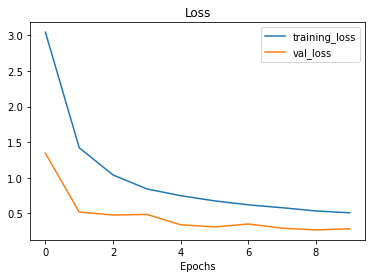

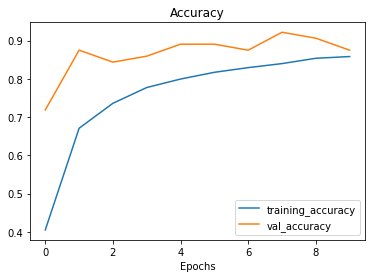

In [ ]:
#plot loss curves
plot_loss_curves(history)

### Making predictions with our trained model

In [ ]:
# Make predictions on the model
preds_prob = model.predict(test_data, verbose=1)

16/16 [==============================] - 10s 346ms/step


In [ ]:
# Get the pred classes of each label
pred_classes = preds_prob.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0, 11,  0,  0,  1,  1,  1,  1,  1])

In [ ]:
# To get our test labels we need to unravel our test_data Batchdataset
y_labels = []

for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

### Let's get visual: making a confusion matrix

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['air hockey',
 'ampute football',
 'archery',
 'arm wrestling',
 'axe throwing',
 'balance beam',
 'barell racing',
 'baseball',
 'basketball',
 'baton twirling']

### Visualizing predictions on test_data

In [ ]:
# Create a function to load and pepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into 
  specified shape (224, 224, 3)

  Args:
  filename (str): path to target image
  image_shape (int): height/weight dimension of target image size
  scale (bool): scale pixel value from 0-255 to 0-1 or not

  Returns:
  Image tensor of shape (224, 224, 3)
  """

  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/No
  if scale:
    # rescale the image (get all values between 0 & 1)
    return img/255.
  else:
    return img
    

In [ ]:
import matplotlib.pyplot as plt

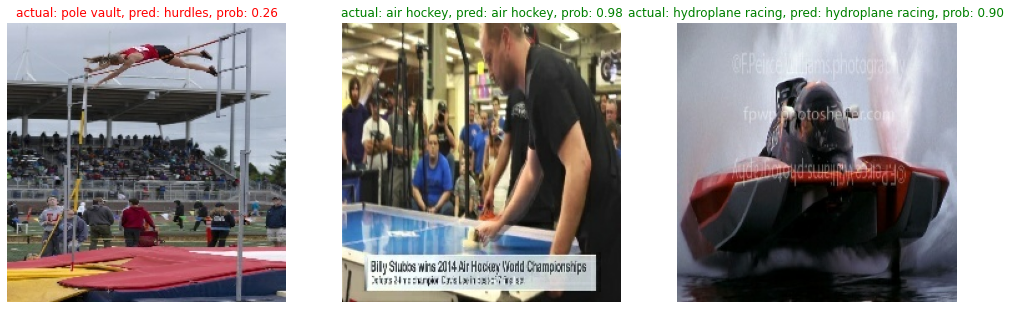

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

#### Saving the model

In [ ]:
model.save("/content/drive/MyDrive/Saved Models/100-Images-Sports-Classification..h5")

#### Test out our model on custom images

In [43]:
!unzip "/content/drive/MyDrive/Raw_dataset/images-to-predict.zip" -d "/content/drive/MyDrive/Data"

Archive:  /content/drive/MyDrive/Raw_dataset/images-to-predict.zip
  inflating: /content/drive/MyDrive/Data/images to predict/1.jpg  
  inflating: /content/drive/MyDrive/Data/images to predict/5.jpg  
  inflating: /content/drive/MyDrive/Data/images to predict/6.jpg  
  inflating: /content/drive/MyDrive/Data/images to predict/boxing.jpg  
  inflating: /content/drive/MyDrive/Data/images to predict/fencing.jpg  
  inflating: /content/drive/MyDrive/Data/images to predict/football.jpg  
  inflating: /content/drive/MyDrive/Data/images to predict/formular one.jpg  
  inflating: /content/drive/MyDrive/Data/images to predict/frisbee.jpg  
  inflating: /content/drive/MyDrive/Data/images to predict/golf.jpg  
  inflating: /content/drive/MyDrive/Data/images to predict/horse racing.jpg  
  inflating: /content/drive/MyDrive/Data/images to predict/soccer.jpg  


In [44]:
# Get the custom food image filepahs
custom_food_images = ["/content/drive/MyDrive/Data/images to predict/"+ img_path for img_path in os.listdir("/content/drive/MyDrive/Data/images to predict")]
custom_food_images

['/content/drive/MyDrive/Data/images to predict/1.jpg',
 '/content/drive/MyDrive/Data/images to predict/5.jpg',
 '/content/drive/MyDrive/Data/images to predict/6.jpg',
 '/content/drive/MyDrive/Data/images to predict/boxing.jpg',
 '/content/drive/MyDrive/Data/images to predict/fencing.jpg',
 '/content/drive/MyDrive/Data/images to predict/football.jpg',
 '/content/drive/MyDrive/Data/images to predict/formular one.jpg',
 '/content/drive/MyDrive/Data/images to predict/frisbee.jpg',
 '/content/drive/MyDrive/Data/images to predict/golf.jpg',
 '/content/drive/MyDrive/Data/images to predict/horse racing.jpg',
 '/content/drive/MyDrive/Data/images to predict/soccer.jpg']

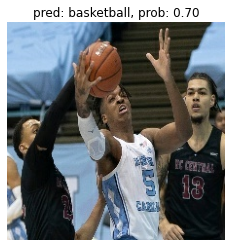

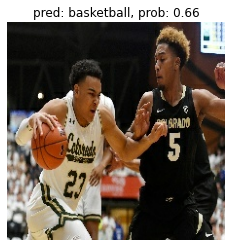

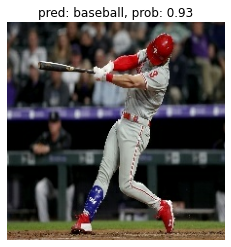

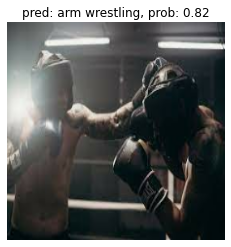

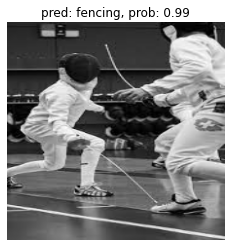

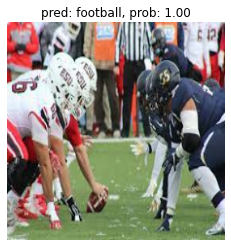

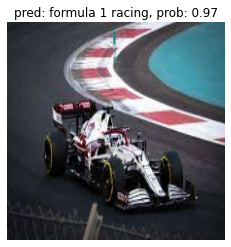

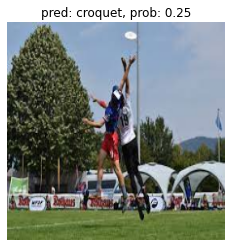

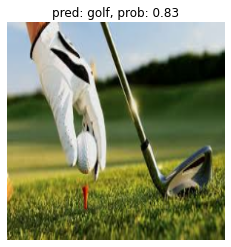

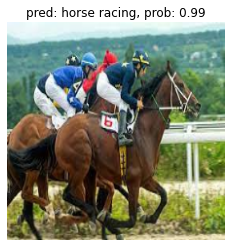

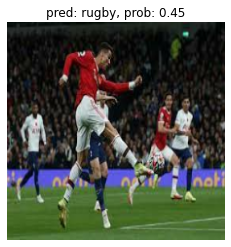

In [45]:
# Make predictions on custom food images and plot them
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  # Plot the appropriate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)